In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
#Loading raw data and do data Exploration
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
attributes = pd.read_csv('attributes.csv')
description = pd.read_csv('product_descriptions.csv')

In [3]:
#check content
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
print(str(df_train.describe()))
df_train.product_uid.value_counts()
attributes.name.value_counts()

                  id    product_uid     relevance
count   74067.000000   74067.000000  74067.000000
mean   112385.709223  142331.911553      2.381634
std     64016.573650   30770.774864      0.533984
min         2.000000  100001.000000      1.000000
25%     57163.500000  115128.500000      2.000000
50%    113228.000000  137334.000000      2.330000
75%    168275.500000  166883.500000      3.000000
max    221473.000000  206650.000000      3.000000


MFG Brand Name                          86250
Bullet02                                86248
Bullet03                                86226
Bullet04                                86174
Bullet01                                85940
Product Width (in.)                     61137
Bullet05                                60529
Product Height (in.)                    54698
Product Depth (in.)                     53652
Product Weight (lb.)                    45175
Bullet06                                44901
Color Family                            41508
Bullet07                                34349
Material                                31500
Color/Finish                            28564
Bullet08                                26645
Certifications and Listings             24583
Bullet09                                20567
Assembled Height (in.)                  18299
Assembled Width (in.)                   18263
Assembled Depth (in.)                   18198
Product Length (in.)              

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

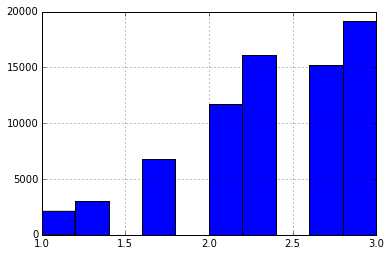

In [6]:
#data visualization
# check the label data distribution 
%matplotlib inline
df_train.relevance.hist()
df_train.relevance.value_counts()

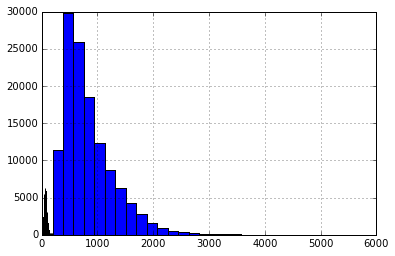

In [7]:
#check feature distribution
description.product_description.str.len().hist(bins=30)
df_train.product_title.str.len().hist(bins=30)

In [8]:
#Add a full set,add descriptions to the full set
df_train['label'] = 'train'
df_test['label'] = 'test'
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, description, how='left', on='product_uid')

In [9]:
#Text data clearing, stop words or SnowballStemmer, NLP 
#Remove unreadable or non-sense words
stemmer = SnowballStemmer('english')
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

In [10]:
#create new features using current feature
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

In [11]:
# drop old features and set final traning dataset, test_dataset
df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all[df_all.label == 'train']
df_test = df_all[df_all.label == 'test']
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance', 'label'],axis=1).values
X_test = df_test.drop(['id','relevance', 'label'],axis=1).values

In [12]:
#Model fitting and get the output
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [13]:
# Model Evalution,  use RMSE (required by the holder) to check the performance 
def fmean_squared_error(ground_truth, predictions):
    rmse = mean_squared_error(ground_truth, predictions)**0.5
    return rmse
# 1st Submission 
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

In [16]:
#Above is simple single model 
#Improve Performance, we could do more feature engineering for those text data 
#top15 search term co-occurrence matrix

